In [1]:
import math
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
    
def blsprice(Price, Strike, Rate, Time, Volatility):
    sigma_sqrtT = Volatility * np.sqrt (Time)

    d1 = 1 / sigma_sqrtT * (np.log(Price / Strike) + (Rate + Volatility**2 / 2) * Time)
    d2 = d1 - sigma_sqrtT

    phi1 = norm.cdf(d1)
    phi2 = norm.cdf(d2)
    disc = np.exp (-Rate * Time)
    F    = Price * np.exp ((Rate) * Time)

    Call = disc * (F * phi1 - Strike * phi2)
    Put  = disc * (Strike * (1 - phi2) + F * (phi1 - 1))
    return Call, Put

def blsdelta(Price, Strike, Rate, Time, Volatility):
    d1 = 1 / (Volatility * np.sqrt(Time)) * (np.log (Price / Strike) + (Rate + Volatility**2 / 2) * Time)

    phi = norm.cdf(d1)

    CallDelta = phi
    PutDelta = phi - 1
    return CallDelta, PutDelta

In [2]:
sigma = 0.30 # volatility
r = 0.04 # risk-free rate
T = 1.2 # years to expiry
K = 100 # strike price
S0 = 100 # initial asset price
mu = 0.08 # real world drift
N = np.array([10, 100, 1000, 10000], dtype=object) # number of hedging rebalances

In [3]:
def deltahedge(n): # n is the nunber of hedging rebalances
    # initial position:
    V0 = blsprice(S0, K, r, T, sigma)[0] # option value
    alpha0 = blsdelta(S0, K, r, T, sigma)[0]
    B0 = V0 - alpha0*S0
    V = V0
    
    delt = T/n
    time = np.linspace(0, T, num=n+1)
    
    alpha = np.ones(n)*alpha0
    S = np.ones(n+1)*S0 # stock price
    B = np.ones(n+1)*B0 # risk free account
    SH = np.ones(n+1)*alpha0*S0 # stock holding
    Pi = np.ones(n+1)*(-V0 + alpha0*S0 + B0) # total portfolio value
    
    # for time steps 1 to (N-1):
    for i in (np.arange(n-1)+1):
        phi = np.random.normal(0,1)
        S[i] = S[i-1]*math.exp((mu-sigma**2/2)*delt + sigma*phi*math.sqrt(delt))
        alpha[i] = blsdelta(S[i], K, r, T-i*delt, sigma)[0]
        V = blsprice(S[i], K, r, T-i*delt, sigma)[0]
        SH[i] = S[i]*alpha[i]
        B[i] = math.exp(r*delt)*B[i-1] - S[i]*(alpha[i]-alpha[i-1])
        Pi[i] = -V + alpha[i]*S[i] + B[i]
    
    # for time step N
    phi = np.random.normal(0,1)
    S[n] = S[n-1]*math.exp((mu-sigma**2/2)*delt + sigma*phi*math.sqrt(delt))
    SH[n] = S[n]*alpha[-1]
    B[n] = math.exp(r*delt)*B[n-1]
    Pi[n] = -np.maximum(S[n]-K, 0) + SH[n] + B[n]
    
    RHE = math.exp(-r*T)*Pi[-1]/V0 # relative hedging error
    
    
    plt.plot(time, S) 
    plt.plot(time, B) 
    plt.plot(time, SH) 
    plt.plot(time, Pi) 
    plt.legend(np.array(["Stock Price", "Risk Free Account", "Stock Holding", "Total Portfolio Value"]),
              bbox_to_anchor=(1.05, 1))
    plt.show()
    
    return RHE
        
    

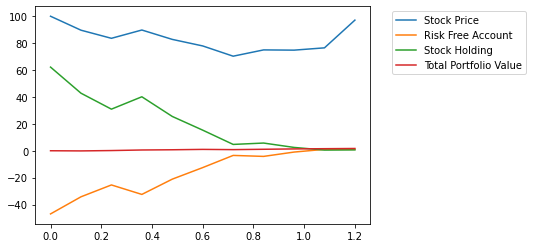

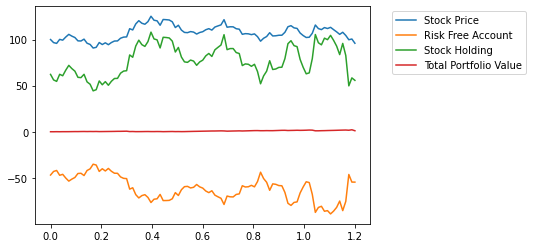

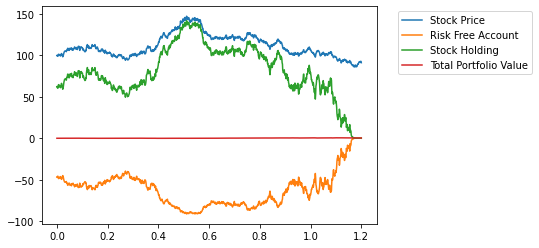

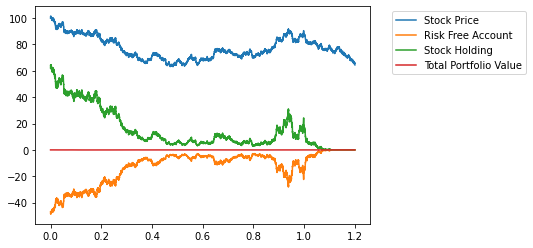

N,relative hedging error
10,0.105488
100,0.067956
1000,0.018977
10000,0.000347


In [142]:
np.random.seed(20702098)
error = np.zeros(np.size(N))

for j in np.arange(np.size(N)):
    error[j] = deltahedge(N[j])

tbl  = np.transpose([N, error])
dftbl = pd.DataFrame(tbl,columns=["N","relative hedging error"])
display(dftbl.style.hide_index()) 

Observations:
1. the total portfolio values stays relatively close to zero during the entire holding period with delta hedging implemented.
2. The relative hedging error decreases with the increase of number of hedging rebalances.
3. The stock holding is positively related to stock price, while the risk free account (bond) is negatively related to stock price in general, and the position of stock holdings and risk free account (bond) behave symmetric against 0.
